In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 72
lag_exp=24

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [10]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

In [11]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [12]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [13]:
# Load Data
data = pd.read_csv('T1.csv', index_col='Date/Time')

In [14]:
data.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [18]:
# Drop columns
data = data.drop(['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)'], axis=1)

In [19]:
data.head()

,Wind Direction (°)
Date/Time,
01 01 2018 00:00,259.994904
01 01 2018 00:10,268.641113
01 01 2018 00:20,272.564789
01 01 2018 00:30,271.258087
01 01 2018 00:40,265.674286


In [21]:
# Last five rows
data.tail()

,Wind Direction (°)
Date/Time,
31 12 2018 23:10,80.502724
31 12 2018 23:20,84.062599
31 12 2018 23:30,84.742500
31 12 2018 23:40,84.297913
31 12 2018 23:50,82.274620


In [22]:
# number of rows in dataset
data.shape

(50530, 1)

In [23]:
# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

In [24]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [25]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [26]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [27]:
model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


50457/50457 [==============================] - 132s 3ms/step - loss: 0.0105


In [28]:
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(model, 1, X)#batch_size_exp to 1

    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 420ms/step
Hour=1, Predicted=86.677959, Expected=87.310623
1/1 [==============================] - 0s 25ms/step
Hour=2, Predicted=87.777589, Expected=89.737091
1/1 [==============================] - 0s 27ms/step
Hour=3, Predicted=96.936687, Expected=82.736252
1/1 [==============================] - 0s 25ms/step
Hour=4, Predicted=72.374856, Expected=81.974297
1/1 [==============================] - 0s 26ms/step
Hour=5, Predicted=84.738065, Expected=73.194389
1/1 [==============================] - 0s 27ms/step
Hour=6, Predicted=74.986302, Expected=75.005074
1/1 [==============================] - 0s 25ms/step
Hour=7, Predicted=84.543271, Expected=79.551987
1/1 [==============================] - 0s 24ms/step
Hour=8, Predicted=72.512231, Expected=76.018478
1/1 [==============================] - 0s 26ms/step
Hour=9, Predicted=73.265489, Expected=78.276291
1/1 [==============================] - 0s 24ms/step
Hour=10, Predicted=79.339063, Expected=68.14553

In [29]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  3.481257506059648


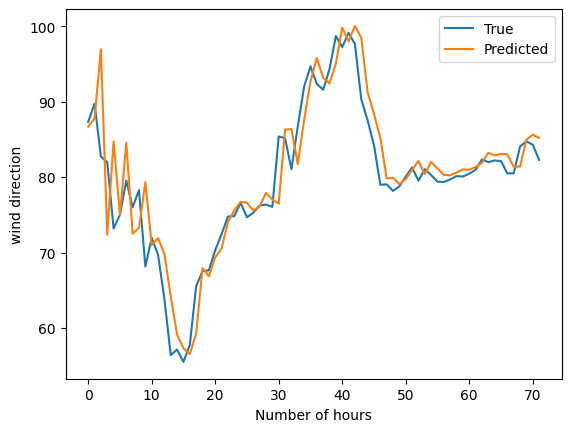

In [31]:
# line plot of observed vs predicted
plt.plot(raw_values[-predict_values_exp:], label="True")
plt.plot(predictions, label="Predicted")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("wind direction")
plt.show()

In [32]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [43]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)